In [1]:
from operator import itemgetter
import re

import numpy as np
import pandas as pd



In [2]:

get_unit_and_periods = itemgetter('unit', 'periods')


def parse_treasury_csv_column(column):
    """
    Parse a treasury CSV column into a more human-readable format.
    Columns start with 'RIFLGFC', followed by Y or M (year or month), followed
    by a two-digit number signifying number of years/months, followed by _N.B.
    We only care about the middle two entries, which we turn into a string like
    3month or 30year.
    """
    column_re = re.compile(
        r"^(?P<prefix>RIFLGFC)"
        "(?P<unit>[YM])"
        "(?P<periods>[0-9]{2})"
        "(?P<suffix>_N.B)$"
    )

    match = column_re.match(column)
    if match is None:
        raise ValueError("Couldn't parse CSV column %r." % column)
    unit, periods = get_unit_and_periods(match.groupdict())

    # Roundtrip through int to coerce '06' into '6'.
    return str(int(periods)) + ('year' if unit == 'Y' else 'month')


def earliest_possible_date():
    """
    The earliest date for which we can load data from this module.
    """
    # The US Treasury actually has data going back further than this, but it's
    # pretty rare to find pricing data going back that far, and there's no
    # reason to make people download benchmarks back to 1950 that they'll never
    # be able to use.
    return pd.Timestamp('2010', tz='UTC')


def get_treasury_data(start_date, end_date):
    return pd.read_csv(
        "https://www.federalreserve.gov/datadownload/Output.aspx"
        "?rel=H15"
        "&series=bf17364827e38702b42a58cf8eaa3f78"
        "&lastObs="
        "&from="  # An unbounded query is ~2x faster than specifying dates.
        "&to="
        "&filetype=csv"
        "&label=include"
        "&layout=seriescolumn"
        "&type=package",
        skiprows=5,  # First 5 rows are useless headers.
        parse_dates=['Time Period'],
        na_values=['ND'],  # Presumably this stands for "No Data".
        index_col=0,
    ).loc[
        start_date:end_date
    ].dropna(
        how='all'
    ).rename(
        columns=parse_treasury_csv_column
    ).tz_localize('UTC') * 0.01  # Convert from 2.57% to 0.0257.


def dataconverter(s):
    try:
        return float(s) / 100
    except Exception:
        return np.nan


def get_daily_10yr_treasury_data():
    """Download daily 10 year treasury rates from the Federal Reserve and
    return a pandas.Series."""
    url = "https://www.federalreserve.gov/datadownload/Output.aspx?rel=H15" \
          "&series=bcb44e57fb57efbe90002369321bfb3f&lastObs=&from=&to=" \
          "&filetype=csv&label=include&layout=seriescolumn"
    return pd.read_csv(url, header=5, index_col=0, names=['DATE', 'BC_10YEAR'],
                       parse_dates=True, converters={1: dataconverter},
                       squeeze=True)

In [10]:
get_treasury_data('2019-10-01','2019-10-10')

,1month,3month,6month,1year,2year,3year,5year,7year,10year,20year,30year
Time Period,,,,,,,,,,,
2019-10-01 00:00:00+00:00,0.0179,0.0182,0.0181,0.0173,0.0156,0.0151,0.0151,0.0159,0.0165,0.0193,0.0211
2019-10-02 00:00:00+00:00,0.0175,0.0179,0.0175,0.0167,0.0148,0.0143,0.0143,0.0153,0.0160,0.0190,0.0209
2019-10-03 00:00:00+00:00,0.0178,0.0170,0.0166,0.0158,0.0139,0.0134,0.0134,0.0145,0.0154,0.0185,0.0204
2019-10-04 00:00:00+00:00,0.0173,0.0171,0.0165,0.0158,0.0140,0.0135,0.0134,0.0143,0.0152,0.0181,0.0201
2019-10-07 00:00:00+00:00,0.0176,0.0175,0.0173,0.0164,0.0146,0.0141,0.0138,0.0147,0.0156,0.0185,0.0205
2019-10-08 00:00:00+00:00,0.0169,0.0172,0.0169,0.0162,0.0142,0.0138,0.0136,0.0145,0.0154,0.0184,0.0204
2019-10-09 00:00:00+00:00,0.0169,0.0169,0.0169,0.0159,0.0147,0.0143,0.0140,0.0150,0.0159,0.0188,0.0208
2019-10-10 00:00:00+00:00,0.0174,0.0168,0.0168,0.0163,0.0153,0.0149,0.0148,0.0157,0.0167,0.0196,0.0216


In [11]:
check=get_daily_10yr_treasury_data()

DATE
1962-01-02    0.0406
1962-01-03    0.0403
1962-01-04    0.0399
1962-01-05    0.0402
1962-01-08    0.0403
Name: BC_10YEAR, dtype: float64

C:\Users\manas\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


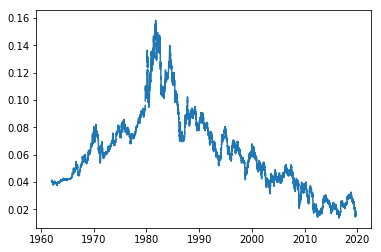

In [16]:
plt.plot(check)

In [15]:
import matplotlib.pyplot as plt 